In [1]:
import numpy as np
import tensorflow as tf

import sklearn
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from IPython import display
import time
%matplotlib inline

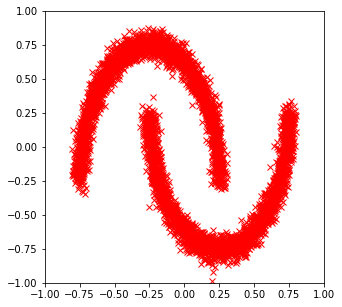

In [2]:
s,label=sklearn.datasets.make_moons(n_samples=5000,noise=.05)
s[:,1]=s[:,1]*2
s-=.5
s=s*.5
plt.figure(figsize=(5,5))
plt.plot(s[:,0],s[:,1],'rx')
plt.axis([-1,1,-1,1])
plt.show()

In [17]:
def plot_node(sess, x_input, output, ax, title):
    X, Y = np.meshgrid(np.linspace(-1, 1, num = 100), np.linspace(-1, 1, num = 100))
    x = np.concatenate((np.reshape(X, (10000, 1)), np.reshape(Y, (10000, 1))), 1)
    out = sess.run((node), feed_dict = {x_input: x})

    kde = KernelDensity(bandwidth = .05)
    kde.fit(X = s)
    I = np.exp(kde.score_samples(x))
    ax.imshow(np.reshape(I, (100, 100)), cmap = cm.hot)
    ax.contour(50 * X + 50, 50 * Y + 50, np.reshape(out[: , 0], (100, 100)), 20, colors = "w", linestyles = "solid")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

In [38]:
def weight_variable(shape):
    w = tf.random_normal(shape, dtype=tf.float32, seed=0)
    initial = w/tf.norm(w, axis=0, keepdims=True)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0., shape = shape, dtype=tf.float32)
    return tf.Variable(initial)

def build_mlp_graph(activation_f):
    np.random.seed(123)
    tf.random.set_random_seed(123)
    d = 2
    L1 = 50
    L2 = 100
    L3 = 1

    x_input = tf.placeholder(dtype = tf.float32, shape = (None, d))
    y_input = tf.placeholder(tf.int64, shape = (None))

    theta1 = weight_variable((d, L1))
    b1 = bias_variable((L1, ))
    theta2 = weight_variable((L1, L2))
    b2 = bias_variable((L2, ))
    theta3 = weight_variable((L2, L3))
    b3 = bias_variable((L3, ))
    theta4 = weight_variable((L3, 2))
    b4 = bias_variable((2, ))

    x0 = tf.matmul(x_input, theta1) + b1
    x1 = activation_f(x0)
    x2 = activation_f(tf.matmul(x1, theta2) + b2)
    x3 = activation_f(tf.matmul(x2, theta3) + b3)
    pred = tf.nn.softmax(tf.matmul(x3, theta4) + b4)

    cross_entropy = tf.reduce_mean(-tf.one_hot(y_input, 2) * tf.log(pred))
    train = tf.train.AdamOptimizer(learning_rate = 0.005).minimize(cross_entropy)


    correct_prediction = tf.equal(tf.argmax(pred, 1), y_input)
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return (x_input, y_input, train, acc), (x0, x1, x2, x3)

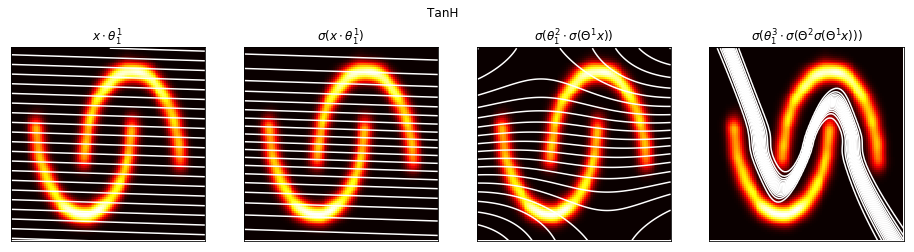

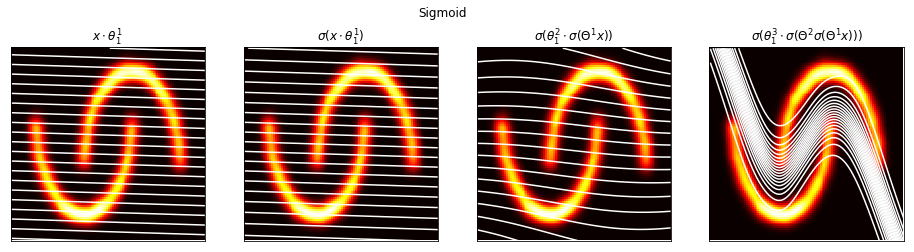

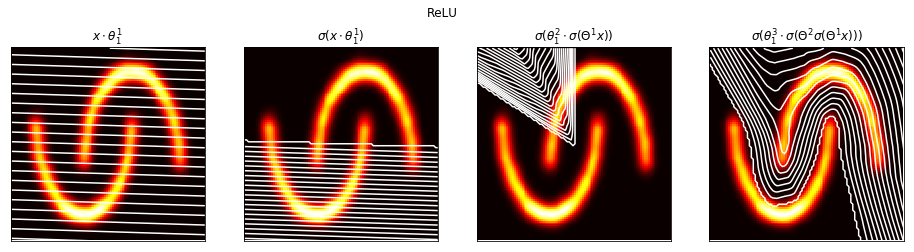

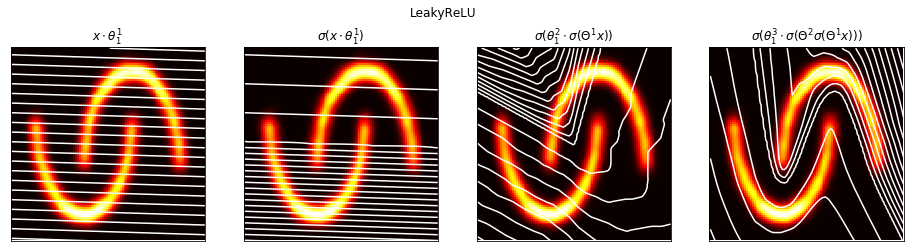

In [40]:
fns = [tf.nn.tanh, tf.nn.sigmoid, tf.nn.relu, tf.nn.leaky_relu]
descs = ['TanH', 'Sigmoid', 'ReLU', 'LeakyReLU']


for fn, desc in zip(fns, descs):
    (x_input, y_input, train, acc), nodes = build_mlp_graph(fn)
    fig, axes = plt.subplots(ncols=4, figsize=(16, 4))
    titles = [r'$x\cdot \theta_1^1$',
              r'$\sigma(x\cdot \theta_1^1)$',
              r'$\sigma(\theta_1^2 \cdot \sigma(\Theta^1 x))$',
              r'$\sigma(\theta_1^3 \cdot \sigma(\Theta^2\sigma(\Theta^1 x)))$'
             ]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i, ax, node, title in zip(range(4), axes, nodes, titles):
            if i == 3:
                for epoch in range(500):
                    _, acc_val = sess.run((train, acc),feed_dict={x_input:s, y_input: label})
            plot_node(sess, x_input, node, ax, title)
            plt.suptitle(desc)
    